In [46]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

In [47]:
def calculate_ece(confidences, accuracies, n_bins=10) -> float:
    """
    Calculate the expected calibration error (ECE) given a list of confidence scores (0-1) and accuracy scores (0 or 1).
    """
    df = pd.DataFrame({"conf": confidences, "acc": accuracies}).dropna()

    confidences = torch.tensor(df["conf"].tolist())
    accuracies = torch.tensor(df["acc"].tolist())
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |confidence - accuracy| in each bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

In [48]:
stats_df = pd.read_csv("../results/model_stats.csv")
stats_df

,Model,n samples after dropna,Tokens more than 1024,Tokens more than 2048,Tokens more than 4096,Tokens more than 10240,Tokens more than 30000,Missing answer,Missing verbal numerical confidence,Missing logit perplexity confidence,...,ECE verbal linguistic confidence,AUROC verbal numerical confidence,AUROC logit perplexity confidence,AUROC verbal linguistic confidence,Mean verbal numerical confidence,Mean logit perplexity confidence,Mean verbal linguistic confidence,Std verbal numerical confidence,Std logit perplexity confidence,Std verbal linguistic confidence
0,Claude-3-5-haiku-20241022,11987,0,0,0,0,0,1,1,12032,...,0.272029,0.675670,0.500000,0.718258,0.899560,NaN,0.871297,0.067097,NaN,0.184980
1,Claude-3-7-sonnet-20250219,12015,0,0,0,0,0,4,2,12032,...,0.117624,0.755177,0.500000,0.746708,0.900033,NaN,0.895601,0.103008,NaN,0.134883
2,Claude-3-haiku-20240307,12028,0,0,0,0,0,1,1,12032,...,0.397478,0.524882,0.500000,0.648901,0.918558,NaN,0.815004,0.045847,NaN,0.273927
3,Deepseek-chat,12023,4,0,0,0,0,9,1,0,...,0.165637,0.757216,0.499090,0.717683,0.895005,0.999999,0.946341,0.089353,0.000055,0.117683
4,Deepseek-reasoner,12032,0,0,0,0,0,0,0,12032,...,0.093665,0.776085,0.500000,0.740565,0.898642,NaN,0.938046,0.116164,NaN,0.098924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Qwen3-4b-think,6284,0,0,0,0,0,309,709,0,...,0.143560,0.782844,0.807764,0.786936,0.931068,0.907151,0.908519,0.088038,0.035354,0.114915
65,Qwen3-8b,11973,0,0,0,0,0,41,26,0,...,0.298905,0.711915,0.571787,0.731689,0.906782,0.949886,0.882217,0.114550,0.031354,0.183353
66,Qwen3-8b-base,9788,0,0,0,0,0,2149,95,0,...,0.307100,0.659527,0.564746,0.728395,0.914800,0.865893,0.858714,0.060891,0.053805,0.214209
67,Qwen3-8b-fp8,11936,0,0,0,0,0,72,41,0,...,0.301337,0.707975,0.571182,0.729782,0.909911,0.948193,0.884491,0.116139,0.031367,0.185239


In [49]:
import pandas as pd
model_info = pd.read_csv("https://docs.google.com/spreadsheets/d/1BftP08doGAxTfq4O4mpO4yM8kTbigyviZDnm1RHh9SI/gviz/tq?tqx=out:csv&sheet=model_info").dropna(how='all').dropna(axis=1, how='all')

# Concatenate them together by column "Model"
merged_data = pd.merge(stats_df, model_info, on='Model', how='inner')
merged_data

,Model,n samples after dropna,Tokens more than 1024,Tokens more than 2048,Tokens more than 4096,Tokens more than 10240,Tokens more than 30000,Missing answer,Missing verbal numerical confidence,Missing logit perplexity confidence,...,Complete,Note,Model Name to Show,Model Family,Model Size,Is MoE,is Reasoning,Is Instruct Tuning,Release Date,is Open Source
0,Claude-3-5-haiku-20241022,11987,0,0,0,0,0,1,1,12032,...,Yes,NaN,Claude3.5-Haiku,Claude,NaN,NaN,False,True,NaN,False
1,Claude-3-7-sonnet-20250219,12015,0,0,0,0,0,4,2,12032,...,Yes,NaN,Claude3.7-Sonnet,Claude,175.0,NaN,True,True,NaN,False
2,Claude-3-haiku-20240307,12028,0,0,0,0,0,1,1,12032,...,Yes,NaN,Claude3-Haiku,Claude,NaN,NaN,False,True,NaN,False
3,Deepseek-chat,12023,4,0,0,0,0,9,1,0,...,Yes,NaN,Deepseek-V3,Deepseek,671.0,True,False,True,NaN,True
4,Deepseek-reasoner,12032,0,0,0,0,0,0,0,12032,...,Yes,NaN,Deepseek-R1,Deepseek,671.0,True,True,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Qwen3-4b-think,6284,0,0,0,0,0,309,709,0,...,Yes,NaN,Qwen3-4B,Qwen3,4.0,False,True,True,20240429.0,True
64,Qwen3-8b,11973,0,0,0,0,0,41,26,0,...,Yes,NaN,Qwen3-8B,Qwen3,8.0,False,False,True,20240429.0,True
65,Qwen3-8b-base,9788,0,0,0,0,0,2149,95,0,...,Yes,NaN,Qwen3-8B,Qwen3,8.0,False,False,False,20240429.0,True
66,Qwen3-8b-fp8,11936,0,0,0,0,0,72,41,0,...,Yes,NaN,Qwen3-8B,Qwen3,8.0,False,False,True,20240429.0,True


In [50]:
merged_data.columns

Index(['Model', 'n samples after dropna', 'Tokens more than 1024',
       'Tokens more than 2048', 'Tokens more than 4096',
       'Tokens more than 10240', 'Tokens more than 30000', 'Missing answer',
       'Missing verbal numerical confidence',
       'Missing logit perplexity confidence',
       'Missing verbal linguistic confidence', 'Accuracy',
       'Accuracy without na', 'ECE verbal numerical confidence',
       'ECE logit perplexity confidence', 'ECE verbal linguistic confidence',
       'AUROC verbal numerical confidence',
       'AUROC logit perplexity confidence',
       'AUROC verbal linguistic confidence',
       'Mean verbal numerical confidence', 'Mean logit perplexity confidence',
       'Mean verbal linguistic confidence', 'Std verbal numerical confidence',
       'Std logit perplexity confidence', 'Std verbal linguistic confidence',
       'Complete', 'Note', 'Model Name to Show', 'Model Family', 'Model Size',
       'Is MoE', 'is Reasoning', 'Is Instruct Tuning', 'R

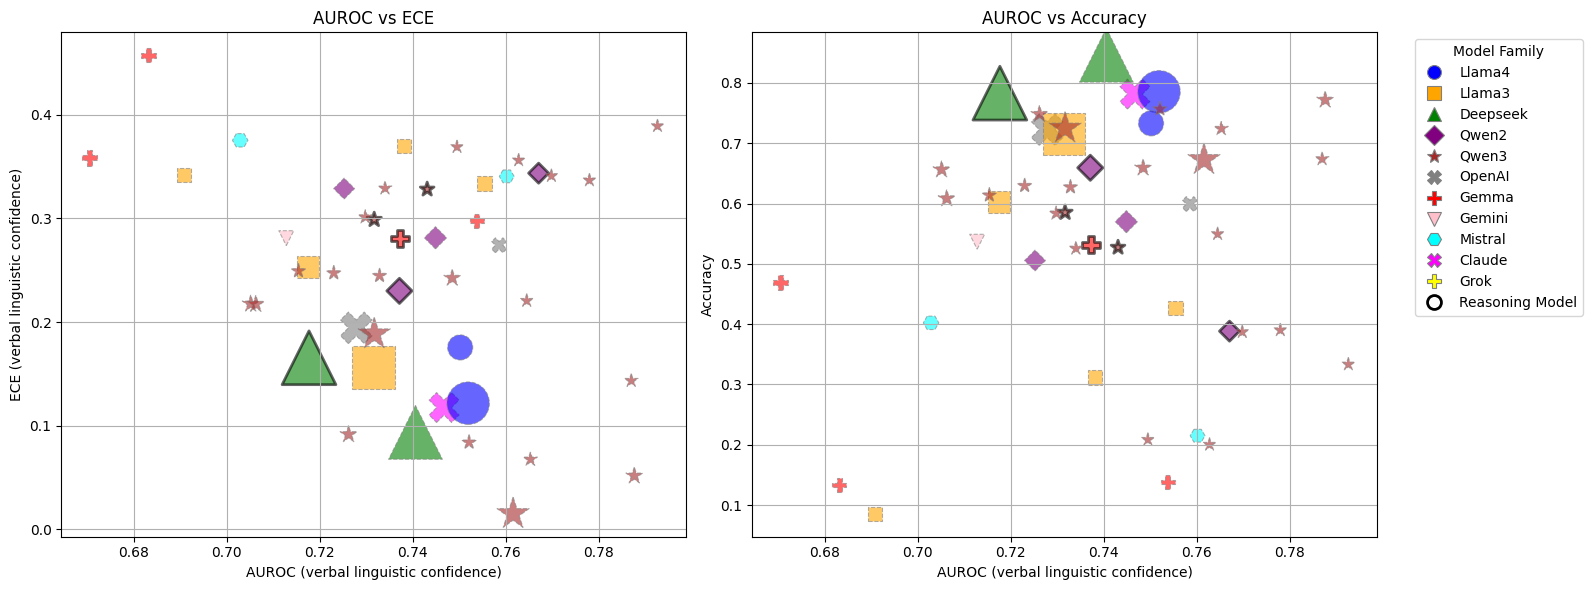

In [51]:
# Specify the confidence extraction method
CONFIDENCE_EXTRACTION_METHOD = "verbal linguistic"

# Define model style mapping: family -> (color, marker)
model_family_styles = {
    'Llama4':   ('blue', 'o'),
    'Llama3':   ('orange', 's'),
    'Deepseek': ('green', '^'),
    'Qwen2':    ('purple', 'D'),
    'Qwen3':    ('brown', '*'),
    'OpenAI':   ('gray', 'X'),
    'Gemma':    ('red', 'P'),
    'Gemini':   ('pink', 'v'),
    'Mistral':  ('cyan', 'H'),
    'Claude':   ('magenta', 'X'), 
    'Grok':     ('yellow', 'P'),  
}

# Extract separate color and marker maps
palette = {fam: color for fam, (color, marker) in model_family_styles.items()}
marker_map = {fam: marker for fam, (color, marker) in model_family_styles.items()}


# Step 1: Data filtering
filtered_data = merged_data[~merged_data['Model'].str.contains('-base')]
# filtered_data = filtered_data[~filtered_data['Model'].str.contains('-think')]
filtered_data = filtered_data[filtered_data[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence'] > 0.53]

# Step 2: Get family
def get_family(model_name):
    for key in model_family_styles.keys():
        if key.lower() in model_name.lower():
            return key
    return 'Other'

filtered_data['Family'] = filtered_data['Model Family'].apply(get_family)
# Edge properties
filtered_data['Edge Color'] = np.where(filtered_data['is Reasoning'], 'black', 'gray')
filtered_data['Line Width'] = np.where(filtered_data['is Reasoning'], 2.0, 0.8)
filtered_data['Line Style'] = np.where(filtered_data['is Reasoning'], 'solid', 'dashed')




# Step 3: Size scaling
min_size, max_size = 100, 1500
sizes = filtered_data['Model Size']
filtered_data['Scaled Size'] = np.interp(sizes, (sizes.min(), sizes.max()), (min_size, max_size))

# Step 4: Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: AUROC vs ECE ---
sns.scatterplot(
    ax=axes[0],
    data=filtered_data,
    x=f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence',
    y=f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence',
    hue='Family',
    palette=palette,
    style='Family',
    markers=marker_map,
    edgecolors=filtered_data['Edge Color'],
    linewidths=filtered_data['Line Width'],
    linestyle=filtered_data['Line Style'],
    size='Scaled Size',
    sizes=(min_size, max_size),
    alpha=0.6,
    legend=False
)

axes[0].set_title("AUROC vs ECE")
axes[0].set_xlabel(f"AUROC ({CONFIDENCE_EXTRACTION_METHOD} confidence)")
axes[0].set_ylabel(f"ECE ({CONFIDENCE_EXTRACTION_METHOD} confidence)")
axes[0].grid(True)

# --- Plot 2: AUROC vs Accuracy ---
sns.scatterplot(
    ax=axes[1],
    data=filtered_data,
    x=f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence',
    y='Accuracy',
    hue='Family',
    palette=palette,
    style='Family',
    markers=marker_map,
    edgecolors=filtered_data['Edge Color'],
    linewidths=filtered_data['Line Width'],
    linestyle=filtered_data['Line Style'],
    size='Scaled Size',
    sizes=(min_size, max_size),
    alpha=0.6,
    legend=False
)
axes[1].set_title("AUROC vs Accuracy")
axes[1].set_xlabel(f"AUROC ({CONFIDENCE_EXTRACTION_METHOD} confidence)")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

# Legend elements
legend_elements = [
    Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
           markerfacecolor=palette[fam], markeredgecolor='gray',
           markeredgewidth=0.8, linestyle='dashed', markersize=10)
    for fam in model_family_styles.keys()
    if fam in filtered_data['Family'].values
]

# Reasoning and Non-Reasoning legend entries
legend_elements.append(
    Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
           markerfacecolor='white', markeredgecolor='black',
           markeredgewidth=2.0, linestyle='solid', markersize=10)
)




axes[1].legend(handles=legend_elements, title='Model Family', bbox_to_anchor=(1.05, 1), loc='upper left')

# Final layout and save
plt.tight_layout()
plt.savefig(f'../plots/model_ece_vs_auroc_{CONFIDENCE_EXTRACTION_METHOD.replace(" ", "_")}.pdf', bbox_inches='tight')
plt.show()

# Model Size vs Uncertanty Estimation

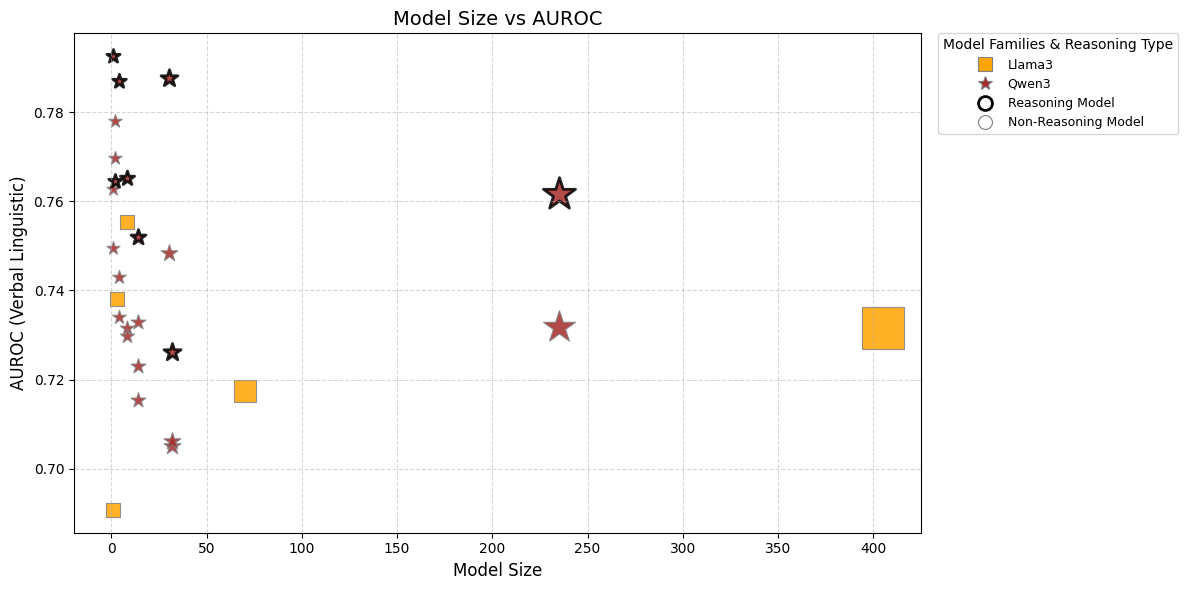

In [52]:
CONFIDENCE_EXTRACTION_METHOD = "verbal linguistic"
UNCERTAINTY_METRIC = "AUROC"
models_of_interest = ["Llama3", "Qwen3"]
fig, ax = plt.subplots(figsize=(12, 6))

for _, row in filtered_data.iterrows():
    x = row['Model Size']
    y = row[f'{UNCERTAINTY_METRIC} {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']
    if family in models_of_interest:
        pass
    else:
        continue

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax.scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax.get_legend_handles_labels()[1] else ""
    )

    # Label model name
    # ax.text(
    #     x, y,
    #     model,
    #     fontsize=8,
    #     ha='center',
    #     va='center',
    #     alpha=0.8
    # )
    ax.set_xlabel("Model Size", fontsize=12)
    ax.set_ylabel(f"{UNCERTAINTY_METRIC} ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=12)
    ax.set_title(f"Model Size vs {UNCERTAINTY_METRIC}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values and fam in models_of_interest
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )
    ax.legend(
        handles=leg,
        title="Model Families & Reasoning Type",
        bbox_to_anchor=(1.02, 1), # move to the right of the plot
        loc='upper left',
        borderaxespad=0,
        fontsize=9,
        title_fontsize=10,
        frameon=True
    )

plt.tight_layout()
plt.show()

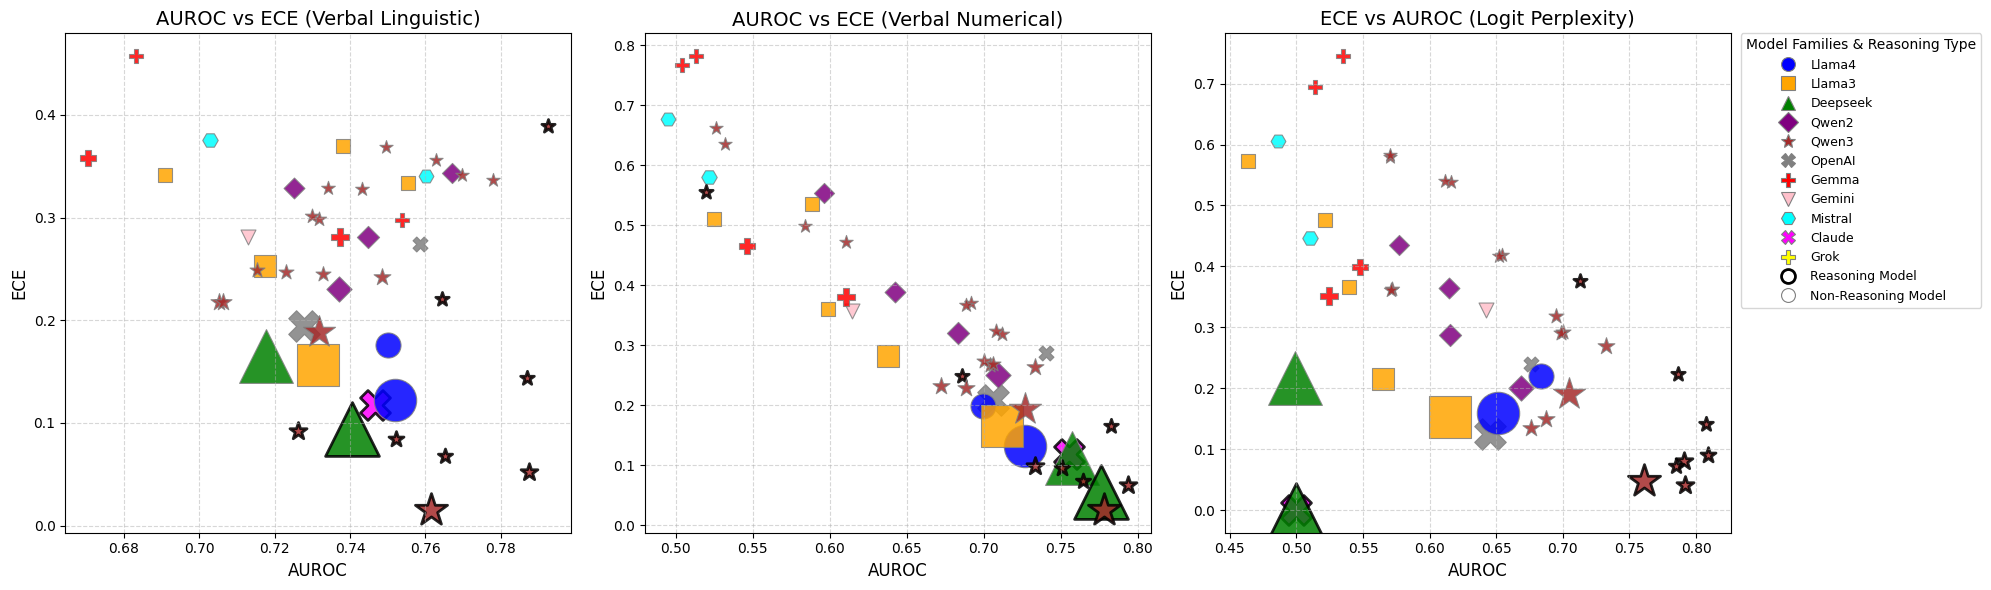

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
CONFIDENCE_EXTRACTION_METHOD = "verbal linguistic"
for _, row in filtered_data.iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[0].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[0].get_legend_handles_labels()[1] else ""
    )

    # Label model name
    # ax.text(
    #     x, y,
    #     model,
    #     fontsize=8,
    #     ha='center',
    #     va='center',
    #     alpha=0.8
    # )
    ax[0].set_xlabel("AUROC", fontsize=12)
    ax[0].set_ylabel(f"ECE", fontsize=12)
    ax[0].set_title(f"AUROC vs ECE ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[0].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[0].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )

CONFIDENCE_EXTRACTION_METHOD = "verbal numerical"
for _, row in filtered_data.iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[1].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[1].get_legend_handles_labels()[1] else ""
    )

    # Label model name
    # ax.text(
    #     x, y,
    #     model,
    #     fontsize=8,
    #     ha='center',
    #     va='center',
    #     alpha=0.8
    # )
    ax[1].set_xlabel("AUROC", fontsize=12)
    ax[1].set_ylabel(f"ECE", fontsize=12)
    ax[1].set_title(f"AUROC vs ECE ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[1].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[1].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )

CONFIDENCE_EXTRACTION_METHOD = "logit perplexity"
for _, row in filtered_data.iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[2].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[2].get_legend_handles_labels()[1] else ""
    )

    # Label model name
    # ax.text(
    #     x, y,
    #     model,
    #     fontsize=8,
    #     ha='center',
    #     va='center',
    #     alpha=0.8
    # )
    ax[2].set_xlabel("AUROC", fontsize=12)
    ax[2].set_ylabel(f"ECE", fontsize=12)
    ax[2].set_title(f"ECE vs AUROC ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[2].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[2].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )
ax[2].legend(
    handles=leg,
    title="Model Families & Reasoning Type",
    bbox_to_anchor=(1.02, 1), # move to the right of the plot
    loc='upper left',
    borderaxespad=0,
    fontsize=9,
    title_fontsize=10,
    frameon=True
)

plt.tight_layout()
plt.show()

# Reasoning Models Achieve the Most Improvement in Uncertainty Estimation

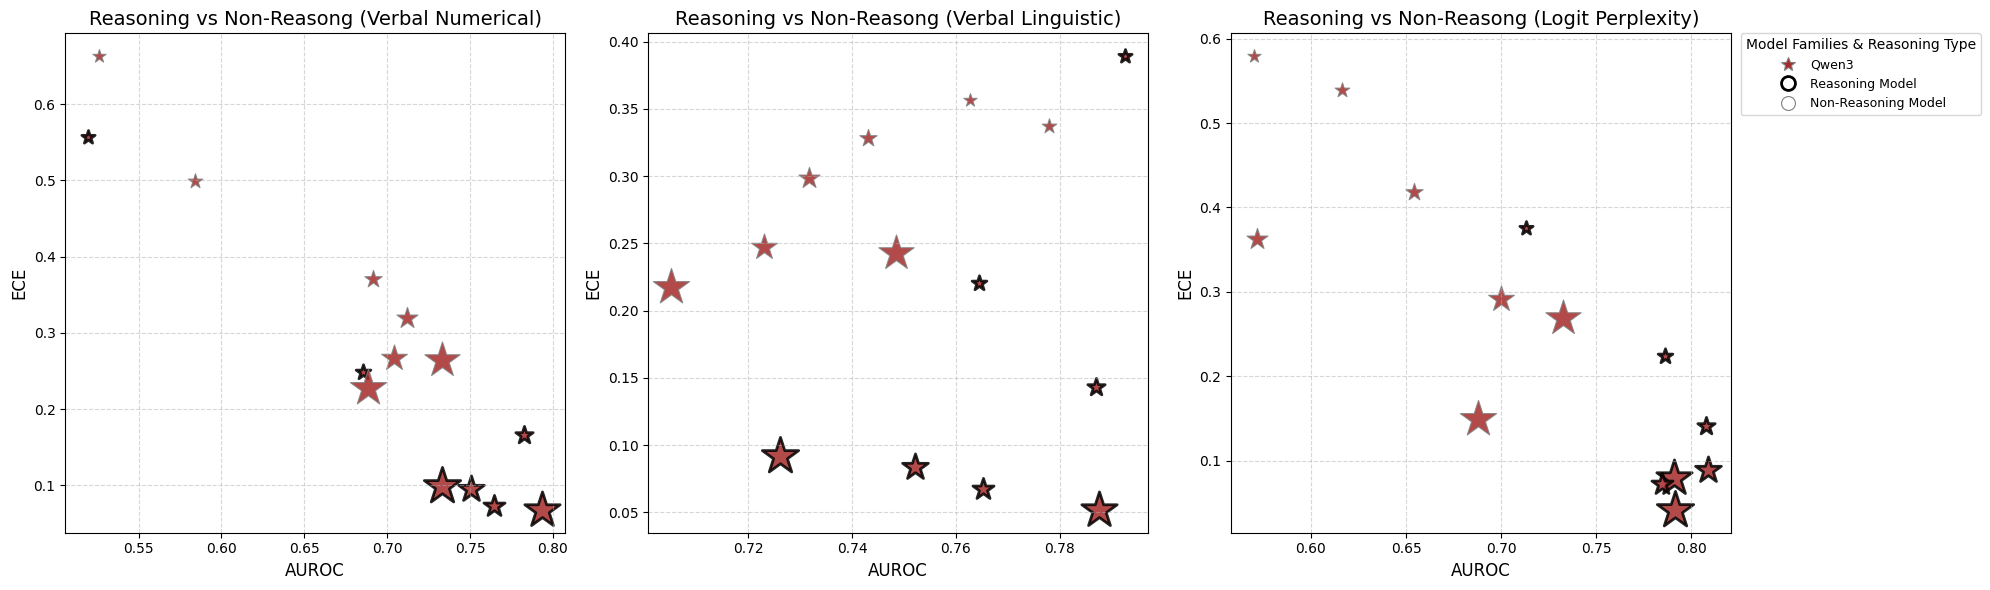

In [ ]:
qwen3 = filtered_data[filtered_data['Family'] == 'Qwen3'].copy()
sizes = qwen3['Model Size']
qwen3['Scaled Size'] = np.interp(sizes, (sizes.min(), sizes.max()), (100, 5000))
qwen3_reasoning = qwen3[(qwen3["is Reasoning"] == True) & (qwen3["Is Instruct Tuning"] == True) & (~qwen3["Model"].str.contains("fp8")) & (~qwen3["Model"].str.contains("base")) & (~qwen3["Model"].str.contains("awq"))]
qwen3_no_reasoning = qwen3[(qwen3["is Reasoning"] == False) & (qwen3["Is Instruct Tuning"] == True) & (~qwen3["Model"].str.contains("fp8")) & (~qwen3["Model"].str.contains("base")) & (~qwen3["Model"].str.contains("awq"))]

models_of_interest = ["Qwen3"]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

CONFIDENCE_EXTRACTION_METHOD = "verbal numerical"
for _, row in pd.concat([qwen3_reasoning, qwen3_no_reasoning]).iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']
    if family in models_of_interest:
        pass
    else:
        continue

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[0].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[0].get_legend_handles_labels()[1] else ""
    )

    
    ax[0].set_xlabel("AUROC", fontsize=12)
    ax[0].set_ylabel(f"ECE", fontsize=12)
    ax[0].set_title(f"Reasoning vs Non-Reasong ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[0].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[0].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values and fam in models_of_interest
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )
CONFIDENCE_EXTRACTION_METHOD = "verbal linguistic"
for _, row in pd.concat([qwen3_reasoning, qwen3_no_reasoning]).iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']
    if family in models_of_interest:
        pass
    else:
        continue

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[1].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[1].get_legend_handles_labels()[1] else ""
    )

    
    ax[1].set_xlabel("AUROC", fontsize=12)
    ax[1].set_ylabel(f"ECE", fontsize=12)
    ax[1].set_title(f"Reasoning vs Non-Reasong ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[1].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[1].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values and fam in models_of_interest
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )

CONFIDENCE_EXTRACTION_METHOD = "logit perplexity"
for _, row in pd.concat([qwen3_reasoning, qwen3_no_reasoning]).iterrows():
    y = row[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']
    if family in models_of_interest:
        pass
    else:
        continue

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row['Scaled Size']
    edge_color = row['Edge Color']
    line_width = row['Line Width']

    # Plot each model
    ax[2].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[2].get_legend_handles_labels()[1] else ""
    )

    
    ax[2].set_xlabel("AUROC", fontsize=12)
    ax[2].set_ylabel(f"ECE", fontsize=12)
    ax[2].set_title(f"Reasoning vs Non-Reasong ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[2].grid(True, linestyle='--', alpha=0.5)

    handles, labels = ax[2].get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    leg = [
            Line2D([0], [0], marker=marker_map[fam], color='w', label=fam,
                markerfacecolor=palette[fam], markeredgecolor='gray',
                markeredgewidth=0.8, linestyle='dashed', markersize=10)
            for fam in model_family_styles.keys()
            if fam in filtered_data['Family'].values and fam in models_of_interest
        ]
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Reasoning Model',
            markerfacecolor='white', markeredgecolor='black',
            markeredgewidth=2.0, linestyle='solid', markersize=10)
    )
    leg.append(
        Line2D([0], [0], marker='o', color='w', label='Non-Reasoning Model',
            markerfacecolor='white', markeredgecolor='gray',
            markeredgewidth=0.8, linestyle='dashed', markersize=10)
    )


ax[2].legend(
        handles=leg,
        title="Model Families & Reasoning Type",
        bbox_to_anchor=(1.02, 1), # move to the right of the plot
        loc='upper left',
        borderaxespad=0,
        fontsize=9,
        title_fontsize=10,
        frameon=True
    )

plt.tight_layout()
plt.show()

# Instruction Fine-Tuning Improves Uncertainty Estimation

In [112]:
qwen3 = merged_data.copy()
qwen3['Family'] = qwen3['Model Family'].apply(get_family)
# Edge properties
qwen3['Edge Color'] = np.where(qwen3['is Reasoning'], 'black', 'gray')
qwen3['Line Width'] = np.where(qwen3['is Reasoning'], 2.0, 0.8)
qwen3['Line Style'] = np.where(qwen3['is Reasoning'], 'solid', 'dashed')

# Step 3: Size scaling
min_size, max_size = 100, 1500
sizes = qwen3['Model Size']
qwen3['Scaled Size'] = np.interp(sizes, (sizes.min(), sizes.max()), (min_size, max_size))

qwen3 = qwen3[qwen3['Family'] == 'Qwen3'].copy()
qwen3_it = qwen3[(qwen3["is Reasoning"] == False) & (qwen3["Is Instruct Tuning"] == True) & (~qwen3["Model"].str.contains("fp8")) & (~qwen3["Model"].str.contains("base")) & (~qwen3["Model"].str.contains("awq")) & (~qwen3["Model"].str.contains("think")) & (~qwen3["Model"].str.contains("32b")) &(~qwen3["Model"].str.contains("1.7b"))].reset_index()
qwen3_base = qwen3[(qwen3["is Reasoning"] == False) & (qwen3["Is Instruct Tuning"] == False)].reset_index()

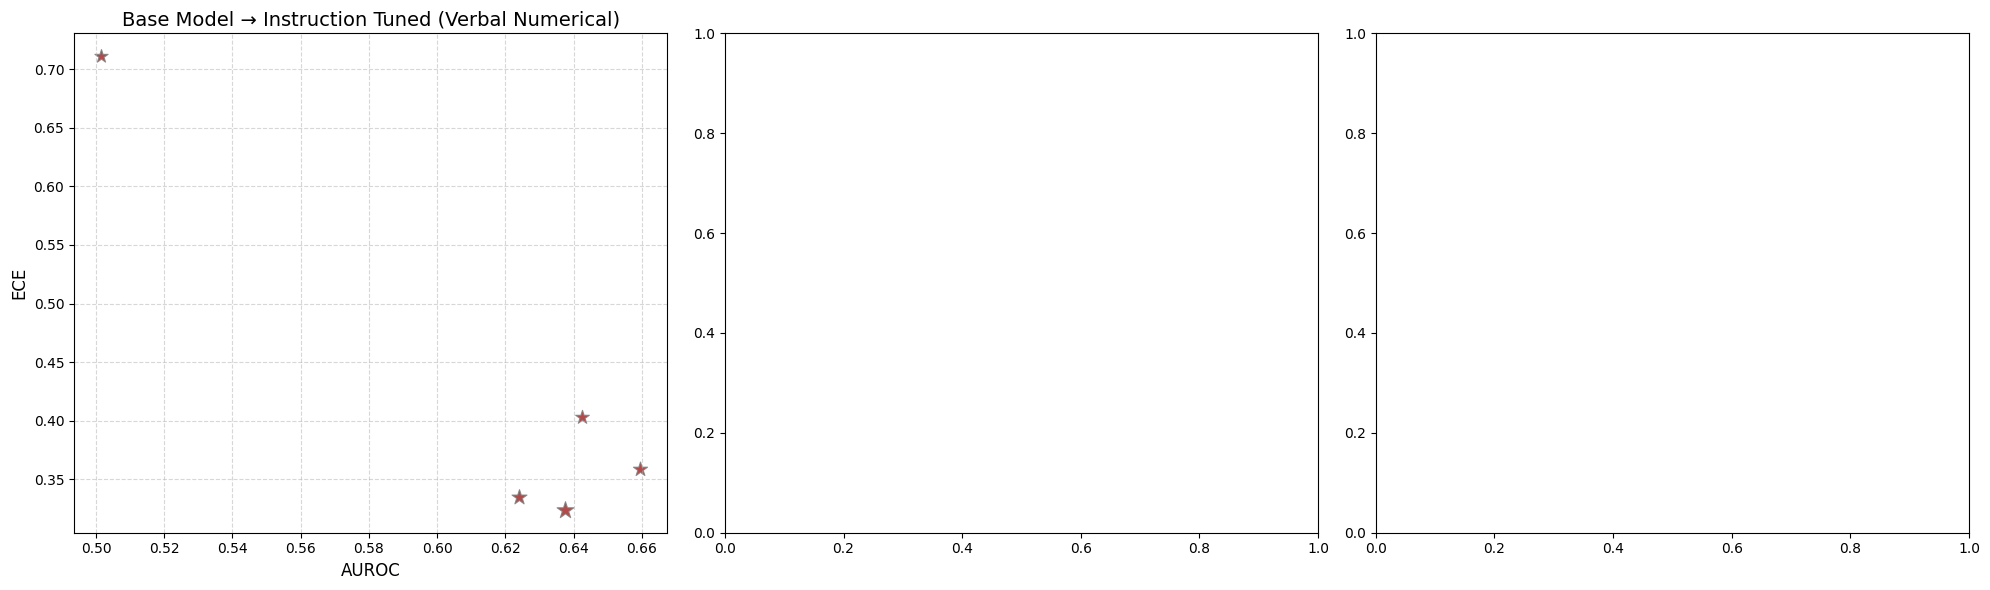

In [ ]:
models_of_interest = ["Qwen3"]

fig, ax = plt.subplots(1, 3, figsize=(20, 6))

CONFIDENCE_EXTRACTION_METHOD = "verbal numerical"
for i, row_base in qwen3_base.iterrows():
    y = row_base[f'ECE {CONFIDENCE_EXTRACTION_METHOD} confidence']
    x = row_base[f'AUROC {CONFIDENCE_EXTRACTION_METHOD} confidence']
    model = row['Model']
    family = row['Family']

    # Style components
    color = palette.get(family, 'black')
    marker = marker_map.get(family, 'o')
    size = row_base['Scaled Size']
    edge_color = row_base['Edge Color']
    line_width = row_base['Line Width']

    # Plot each model
    ax[0].scatter(
        x, y,
        s=size,
        c=color,
        marker=marker,
        edgecolors=edge_color,
        linewidths=line_width,
        alpha=0.85,
        label=family if family not in ax[0].get_legend_handles_labels()[1] else ""
    )

    
    ax[0].set_xlabel("AUROC", fontsize=12)
    ax[0].set_ylabel(f"ECE", fontsize=12)
    ax[0].set_title(f"Base Model → Instruction Tuned ({CONFIDENCE_EXTRACTION_METHOD.title()})", fontsize=14)
    ax[0].grid(True, linestyle='--', alpha=0.5)



# ax[2].legend(
#         handles=leg,
#         title="Model Families & Reasoning Type",
#         bbox_to_anchor=(1.02, 1), # move to the right of the plot
#         loc='upper left',
#         borderaxespad=0,
#         fontsize=9,
#         title_fontsize=10,
#         frameon=True
#     )

plt.tight_layout()
plt.show()

# Correlation between three confidence estimation methods